## Hierarchical Agent Teams

In our previous example ([Agent Supervisor](./agent_supervisor.ipynb)), we introduced the concept of a single supervisor node to route work between different worker nodes.

But what if the job for a single worker becomes too complex? What if the number of workers becomes too large?

For some applications, the system may be more effective if work is distributed _hierarchically_.

You can do this by composing different subgraphs and creating a top-level supervisor, along with mid-level supervisors.

To do this, let's build a simple research assistant! The graph will look something like the following:

![diagram](./img/hierarchical-diagram.png)

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al. In the rest of this notebook, you will:

1. Define the agents' tools to access the web and write files
2. Define some utilities to help create the graph and agents
3. Create and define each team (web research + doc writing)
4. Compose everything together.

But before all of that, some setup:

In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langchain langchain-openai langchain-experimental

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith.
# This will help you visualize and debug the control flow
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Create Tools

Each team will be composed of one or more agents each with one or more tools. Below, define all the tools to be used by your different teams.

We'll start with the research team.

**ResearchTeam tools**

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [3]:
from typing import List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

@tool
def scrape_webpages(urls: list) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information.

    Args:
        urls: list of url strings to scrape
    """
    loader = WebBaseLoader(urls)
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in loader.load()
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


**Document writing team tools**

Next up, we will give some tools for the doc writing team to use.
We define some bare-bones file-access tools below.

Note that this gives the agents access to your file-system, which can be unsafe. We also haven't optimized the tool descriptions for performance.

In [4]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, List, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool
def create_outline(points: list, file_name: str) -> str:
    """Create and save an outline.

    Args:
        points: List of main points or sections.
        file_name: File path to save the outline.

    Returns:
        Path of the saved outline file.
    """
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"

@tool
def read_document(file_name: str, start: Optional[int] = None, end: Optional[int] = None) -> str:
    """Read the specified document.

    Args:
        file_name: File path to save the document.
        start: The start line. Default is 0.
        end: The end line. Default is None.

    Returns:
        The content of the document as a string.
    """
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])

@tool
def write_document(
    content: str,
    file_name: str,
) -> str:
    """Create and save a text document.

    Args:
        content: Text content to be written into the document.
        file_name: File path to save the document.

    Returns:
        Path of the saved document file.
    """
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool
def edit_document(
    file_name: str,
    inserts: Dict[int, str],
) -> str:
    """Edit a document by inserting text at specific line numbers.

    Args:
        file_name: Path of the document to be edited.
        inserts: Dictionary where key is the integer line number (1-indexed) and value is the text to be inserted at that line.
    Returns:
        Path of the edited document file.
    """

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which is unsafe, especially when not sandboxed

repl = PythonREPL()

@tool
def python_repl(
    code: str,
) -> str:
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
    
    Args:
        code: The python code to execute to generate your chart.

    Returns:
        The stdout of the execution.
    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Helper Utilities

We are going to create a few utility functions to make it more concise when we want to:

1. Create a worker agent.
2. Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [5]:
from typing import List, Optional
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI
from datetime import datetime, timezone
from typing import Callable

from langgraph.graph import END, StateGraph


class Worker:
    def __init__(self, name: str, llm: ChatOpenAI, tools: list, system_prompt: str, before: Optional[Callable] = None):
        self.name = name
        system_prompt = (system_prompt
            + "\nWork autonomously according to your specialty, using the tools available to you."
            " Do not ask for clarification."
            " Your other team members (and other teams) will collaborate with you with their own specialties."
            " You must focus exclusively on fulfilling what is in your specialty, as defined by your tools."
            f"\n\n Current time: {datetime.now(tz=timezone.utc).isoformat()}")
        prompt_template = ChatPromptTemplate.from_messages([("system", system_prompt), ("placeholder", "{messages}")])
        self.agent = prompt_template | (lambda prompt_value: {"messages": prompt_value.to_messages()}) | create_react_agent(
            llm,
            tools,
        )
        if before:
            self.agent = before | self.agent

    async def __call__(self, state, config):
        result = await self.agent.ainvoke(state, config)
        # We will name the message to reduce ambiguity
        return {"messages": [AIMessage(content=result["messages"][-1].content, name=self.name)]}


class Supervisor:
    def __init__(self, name: str, llm: ChatOpenAI, members: list) -> str:
        """An LLM-based router."""
        self.name = name
        member_names = [getattr(m, "name", m) for m in members]
        options = ["FINISH"] + member_names
        function_def = {
            "name": "communicate",
            "description": "Select the next role, communicating instructions or results.",
            "parameters": {
                "title": "routeSchema",
                "type": "object",
                "properties": {
                    "next": {
                        "title": "Next",
                        "anyOf": [
                            {"enum": options},
                        ],
                    },
                    "instructions": {
                        "title": "instructions",
                        "type": "string",
                    }
                },
                "required": ["next", "instructions"],
            },
        }
    
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    f"""You are a supervisor (name: {name}) tasked with managing a conversation between the following workers: {", ".join(member_names)}
Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status.
Give the worker a well-defined and scoped task, with a clear, concise deliverable. When finished, respond with FINISH.

Current time: {{current_time}}""",
                ),
                MessagesPlaceholder(variable_name="messages"),
                (
                    "user",
                    "Given the conversation above, who should act next?"
                    f" Or should we FINISH? Select one of: {options}",
                ),
            ]
        ).partial(current_time=datetime.now(tz=timezone.utc).isoformat())
        self.agent = prompt | llm.with_structured_output(
            {"type": "function", "function": function_def}
        )

    async def __call__(self, state, config):
        res = await self.agent.ainvoke(state, config)
        return {
        "next": res["next"],
        "messages": [AIMessage(content=res.get("instructions", ""), name=self.name)],
        }

## Define Agent Teams

Now we can get to define our hierarchical teams. "Choose your player!"

### Research Team

The research team will have a search agent and a web scraping "research_agent" as the two worker nodes. Let's create those, as well as the team supervisor.

In [6]:
import operator
from typing_extensions import Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = Worker(
    "Search",
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)

research_agent = Worker(
    "WebScraper",
    llm,
    [scrape_webpages],
    "You are a research assistant who can scrape specified urls for more detailed information using the scrape_webpages function.",
)

supervisor_agent = Supervisor(
    "ResearchTeamSupervisor",
    llm,
    [search_agent, research_agent],
)

Now that we've created the necessary components, defining their interactions is easy. Add the nodes to the team graph, and define the edges, which determine the transition criteria.

In [7]:
from langgraph.graph import START, END
from typing import Literal

research_graph = StateGraph(ResearchTeamState)
research_graph.add_node(search_agent.name, search_agent)
research_graph.add_node(research_agent.name, research_agent)
research_graph.add_node(supervisor_agent.name, supervisor_agent)

# Define the control flow
research_graph.add_edge(search_agent.name, supervisor_agent.name)
research_graph.add_edge(research_agent.name, supervisor_agent.name)


def route_supervisor(
    state: ResearchTeamState,
):
    match state["next"]:
        case "FINISH":
            return END
        case _:
            return state["next"]


research_graph.add_conditional_edges(supervisor_agent.name, route_supervisor)


research_graph.add_edge(START, supervisor_agent.name)
research_chain = research_graph.compile()

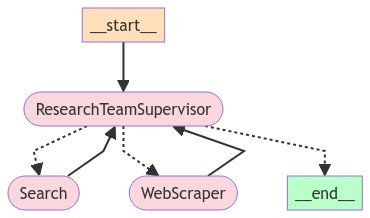

In [8]:
from IPython.display import Image, display

display(Image(research_chain.get_graph(xray=True).draw_mermaid_png()))

We can give this team work directly. Try it out below.

In [10]:
async for s in research_chain.astream_events(
    {"messages": [HumanMessage(content="when is Taylor Swift's next tour?")]}, {"recursion_limit": 100},
    version="v2",
):
    match s['event']:
        case 'on_chat_model_stream':
            print(s['data']['chunk'].content, end='')
            

Taylor Swift's next tour event is part of her "Eras Tour," which will continue internationally in 2024. The tour kicks off with a series of shows at the Tokyo Dome in Japan from February 7-10, 2024. It will then proceed to various countries, with significant performances scheduled until August 16-17, 2024, at Wembley Stadium in London.

For a detailed list of her tour dates and locations, you can visit [Taylor Swift's official tour page](https://www.taylorswift.com/tour/).

### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [11]:
import operator
from pathlib import Path
from langchain_core.runnables import RunnableLambda


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state: DocWritingState):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "At present, no files have been written. Nothing to read."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writing_agent = Worker(
    "DocWriter",
    llm,
    [write_document, edit_document, read_document],
    "You are an expert writing a research document.\n"
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n\n{current_files}",
    before=prelude
)

note_taking_agent = Worker(
    "NoteTaker",
    llm,
    [create_outline, read_document],
    "You are an expert senior researcher tasked with writing a paper outline and"
    " taking notes to craft a perfect paper.\n\n{current_files}",
    before=prelude
)

chart_generating_agent = Worker(
    "ChartGenerator",
    llm,
    [read_document, python_repl],
    "You are a data viz expert tasked with generating charts for a research project.\n\n"
    "{current_files}",
    before=prelude
)

doc_writing_supervisor = Supervisor(
    "DocWritingSupervisor",
    llm,
    [doc_writing_agent, note_taking_agent, chart_generating_agent],
)

With the objects themselves created, we can form the graph.

In [12]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node(doc_writing_agent.name, doc_writing_agent)
authoring_graph.add_node(note_taking_agent.name, note_taking_agent)
authoring_graph.add_node(chart_generating_agent.name, chart_generating_agent)
authoring_graph.add_node(doc_writing_supervisor.name, doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge(START, doc_writing_supervisor.name)
authoring_graph.add_edge(doc_writing_agent.name, doc_writing_supervisor.name)
authoring_graph.add_edge(note_taking_agent.name, doc_writing_supervisor.name)
authoring_graph.add_edge(chart_generating_agent.name, doc_writing_supervisor.name)

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    doc_writing_supervisor.name,
    route_supervisor
)

chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
# We will add a step before the graph to just take the last message.
# Feel free to experiment around with different level of context sharing between teams
authoring_chain = (
    (lambda state: {
            "messages": [HumanMessage(content=state['messages'][-1].content)],
    }) | authoring_graph.compile()
)

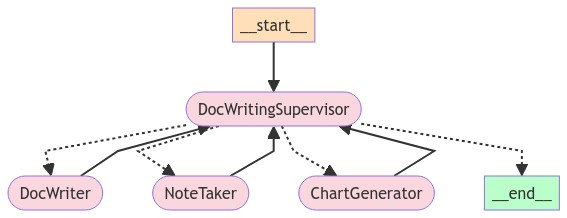

In [13]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [14]:
async for s in authoring_chain.astream_events(
    {"messages": [HumanMessage(content="Write an outline for poem and then write the poem to disk.")]},
    {"recursion_limit": 100},
    version="v2",
):
    match s['event']:
        case 'on_chat_model_stream':
            print(s['data']['chunk'].content, end='')
            

### Outline for the Poem

1. **Introduction**: Set the stage, introduce the theme or subject of the poem.
2. **First Descriptive Stanza**: Provide vivid imagery and details to elaborate on the theme.
3. **Second Descriptive Stanza**: Continue with more imagery and possibly introduce a shift or contrast.
4. **Conclusion**: Summarize the theme, provide closure or a final thought.

### Poem

#### Introduction
In the hush of dawn's first light,
A whisper wakes the sleeping night,
Where dreams and shadows intertwine,
To paint a world both yours and mine.

#### First Descriptive Stanza
Golden rays through leaves do dance,
Casting spells of sweet romance,
Among the blooms, a silent song,
Of nature's grace where hearts belong.

#### Second Descriptive Stanza
Yet in the woods, a storm does brew,
With winds that howl and skies of blue,
Contrasts sharp in life's embrace,
A fleeting glimpse of nature's face.

#### Conclusion
As day gives way to twilight's hue,
We find the old replaced with new,
In

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [15]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = Supervisor(
    "Supervisor", # the big boss
    llm,
    ["ResearchTeam", "PaperWritingTeam"],
)

In [16]:
from langgraph.graph import add_messages
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    next: str


def get_last_message(state: State):
    return {"messages": [HumanMessage(content=state["messages"][-1].content)]}


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node(supervisor_node.name, supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", supervisor_node.name)
super_graph.add_edge("PaperWritingTeam", supervisor_node.name)
super_graph.add_conditional_edges(
    supervisor_node.name,
    route_supervisor,
)
super_graph.add_edge(START, supervisor_node.name)
super_graph = super_graph.compile()

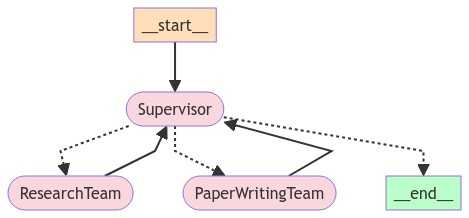

In [17]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [18]:
last_node_name = None
last_streamed_node_name = None
async for s in super_graph.astream_events(
    {
        "messages": [
            HumanMessage(
                content="Draw a graph of sturgeon populations over the years. Cite your sources."
            )
        ],
    },
    {"recursion_limit": 150},
    version="v2"
):
    match s['event']:
        case 'on_chat_model_stream':
            chunk = s['data']['chunk'].content
            if last_streamed_node_name is not last_node_name and chunk:
                print(last_node_name)
                last_streamed_node_name = last_node_name
            print(chunk, end='')
        case 'on_chain_start':
            if node_name := s["metadata"].get("langgraph_node"):
                last_node_name = node_name

APIError: The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error.

In [ ]:
spy